# Demographics and SAT Scores

Higher education is something all people should want and be able to achieve, regardless of whether it is motivated by professional or personal growth. However, many institutes of higher education use, among other things, the Scholastic Aptitude Test, or SAT, score to determine eligibility. In theory this allows schools to be more selective of the students that it admits on basis of probability of academic success. Practically, however, SAT scores may be influenced by external factors that are unrelated to a student's intelligence or academic capacity.

New York City has published SAT scores and demographic data across its schools. As New York City is a very diverse area, that data could show some indication of demographic inequity with regards to SAT scores.


Acknowledgements

# Data: What are we working with?

This data has all been provided by New York City about all of their schools' demographics and SAT scores.

- SAT scores by school: SAT scores for each high school in New York City
- School attendance: Attendance information for each school in New York City
- Class size: Information on class size for each school
- AP test results: Advanced Placement (AP) exam results for each high school (passing an optional AP exam in a particular subject can earn a student college credit in that subject)
- Graduation outcomes: The percentage of students who graduated, and other outcome information
- Demographics: Demographic information for each school
- School survey: Surveys of parents, teachers, and students at each school

# Mission: Demographic Correlation

This project will revolve around examining the relationship between demographics and SAT scores and whether the SAT scores are an equitable means of aptitude assessment. There are a few different distinct questions that we will seek to answer:

- Are there common traits to low-scoring schools that are lesser or even nonexistent in higher-scoring schools?
- Does race have influence on SAT scores?
- How do the schools influence their students' SAT scores?
- How does gender influence SAT scores?

# Read in the data

In [1]:
import pandas as pd
import numpy
import re
import matplotlib.pyplot as plt
data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64


# Plotting survey correlations

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

In [11]:
import matplotlib.pyplot as plt 

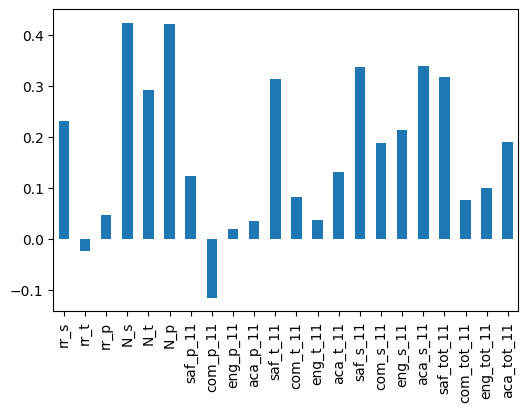

In [12]:
%matplotlib inline
correlation = combined.corr()["sat_score"][survey_fields].plot.bar()

Saf_t_11 and saf_s_11, which measure how teachers and students perceive safety at school, correlated highly with sat_score

There are high correlations between N_s, N_t, N_p and sat_score. These columns are correlated with total_enrollment, therefore it makes agrees that they are high.

The percentage of students that completed the survey correlates with sat_score, rr_s, correlates with sat_score. This might could be because students who are more likely to fill out surveys may be more likely to also be doing well academically.

How students and teachers percieved safety (saf_t_11 and saf_s_11) correlate with sat_score. This make sense, as it's hard to teach or learn in an unsafe environment.

The last interesting correlation is the aca_s_11, which indicates how the student perceives academic standards, correlates with sat_score, but this is not true for aca_t_11, how teachers perceive academic standards, or aca_p_11, how parents perceive academic standards.

# Safety of School vs SAT Scores

Text(0, 0.5, 'SAT Score')

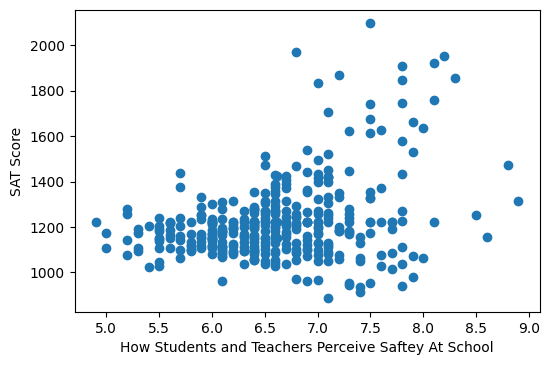

In [13]:
plt.scatter(combined['saf_s_11'], combined['sat_score'])
plt.xlabel('How Students and Teachers Perceive Saftey At School')
plt.ylabel('SAT Score')

There appears to be a slight correlation between SAT scores and safety. Only a small group schools with very high levels of percieved saftey have high SAT scores. No school lower than 6.5 has a SAT score high than 1500, there is no correlation for this range. 

# Safety of Different New York Boroughs

In [14]:
import numpy as np
districts = combined.groupby('boro').agg(np.mean)
districts.reset_index(inplace = True)
districts[['boro','saf_s_11']]

,boro,saf_s_11
0,Bronx,6.606577
1,Brooklyn,6.370755
2,Manhattan,6.831370
3,Queens,6.721875
4,Staten Island,6.530000


On average, the boroughs have similar safety ratings for their schools

# Racial differences in SAT scores

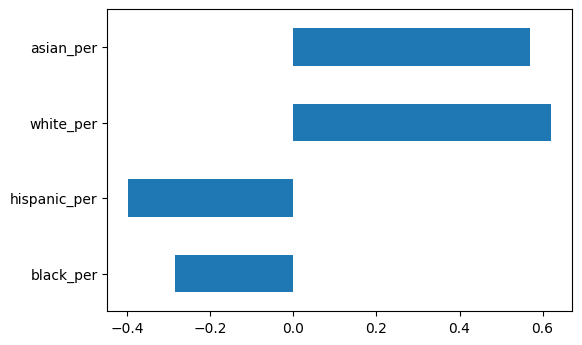

In [15]:
race_fields = ['black_per', 'hispanic_per', 'white_per', 'asian_per']
combined.corr()['sat_score'][race_fields].plot.barh()

While the asian and white student percentage seem to have a positive correlation with SAT scores, the hispanic and black student percentages have a negative correlation. This is a major red flag as this could indicate that the SATs are systemically unfair.

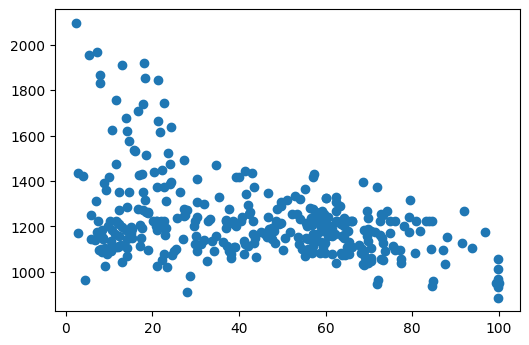

In [16]:
plt.scatter(combined['hispanic_per'],combined['sat_score'])

In [17]:
combined[combined['hispanic_per'] > 95]['SCHOOL NAME']

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

Schools that have over 95% hispanic students, are specialsed towards recent immigrants to the US. Therefore a lot of students are learning English and hence explains lower SAT scores. 

In [18]:
combined[(combined['hispanic_per'] > 10) & (combined['sat_score'] > 1800)]['SCHOOL NAME']

5                         BARD HIGH SCHOOL EARLY COLLEGE
79     HIGH SCHOOL FOR MATHEMATICS, SCIENCE AND ENGIN...
155    HIGH SCHOOL OF AMERICAN STUDIES AT LEHMAN COLLEGE
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

Schools with lower than 10% hispanic students, and have SAT scores greater than 1800 tend to be specialised science and technology schools. 

# Gender differences in SAT scores

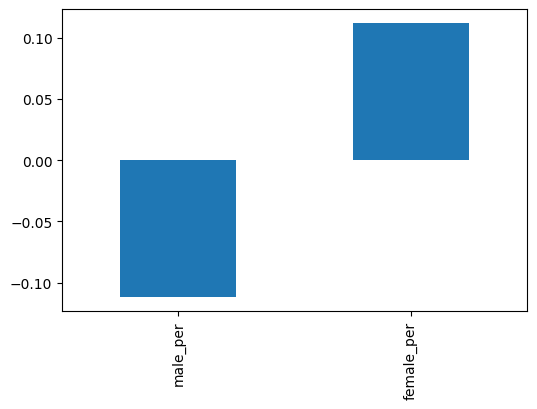

In [19]:
gender = ['male_per','female_per']
combined.corr()['sat_score'][gender].plot.bar()


There is no significant correlation with either female or male students to SAT scores.  

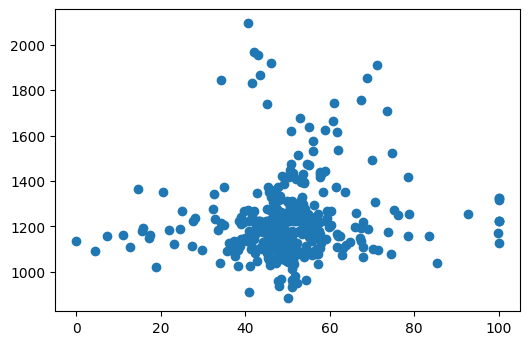

In [20]:
plt.scatter(combined['female_per'], combined['sat_score'])

In [21]:
combined[(combined['female_per'] > 60) & (combined['sat_score'] > 1700)]['SCHOOL NAME']

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

Schools with high percentage of female students (over 60%) and with SAT scores over 1700 are selective liberal arts schools that have high academic standards.

# AP Exam Scores vs SAT Scores

In [22]:
ap_per = combined['AP Test Takers ']/combined['total_enrollment']

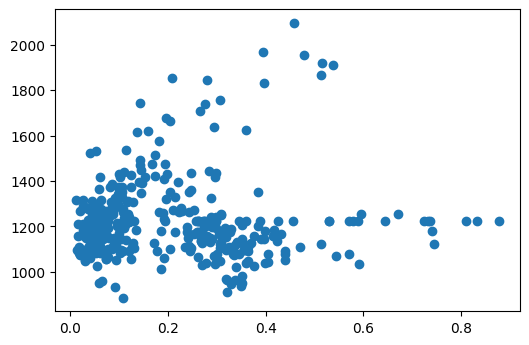

In [23]:
plt.scatter(ap_per,combined['sat_score'])

There is a weak relationship between AP scores and SAT Scores

# Conclusion

Gender, safety and AP scores weakly correlate to SAT scores. Race  correlates to SAT scores, raising concern that some students maybe more disadvantaged than others. Based on this it might cause NYC to look into systematic issues within the schooling system.